<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/Copie_de_ArBert_AuSTR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.1 MB/s eta 0:00:00


In [2]:
#importing packages
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from torch.utils.data import DataLoader
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [3]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
checkpoint_directory = "ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Dataset specification (ans-stance)
raw_datasets = load_dataset("bigIR/AuSTR")
dataset_directory = "AuSTR"
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

AuSTR_train.tsv:   0%|          | 0.00/321k [00:00<?, ?B/s]

AuSTR_dev.tsv:   0%|          | 0.00/112k [00:00<?, ?B/s]

AuSTR_test.tsv:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 488
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

In [5]:
#Evaluation Metrics
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute macro-F1 score
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    # Compute micro-F1 score (for each class)
    micro_f1 = metric.compute(predictions=predictions, references=labels, average="micro")

    return {
        "macro_f1": macro_f1["f1"],
        "micro_f1": micro_f1["f1"]
    }

In [6]:
import os
from datetime import datetime

# Get the current date and time in the desired format
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the folder name by combining the date, time, and custom string
experiment_name = f"{checkpoint_directory}_{dataset_directory}_{current_time}"

# Create the folder
os.makedirs(experiment_name)


# Define the name of the subdirectory inside the main folder
results_directory = "results"
logs_directory = "logs"

# Create the subdirectory inside the main folder
results_path = os.path.join(experiment_name, results_directory)
os.makedirs(results_path)

logs_path = os.path.join(experiment_name, logs_directory)
os.makedirs(logs_path)


# Get the full path (access link) to the subdirectory
experiment_full_path  = os.path.abspath(experiment_name)
results_full_path = os.path.abspath(results_path)
logs_full_path = os.path.abspath(logs_path)

print(f"Results directory: {results_full_path}")
print(f"Logs directory: {logs_full_path}")
print(f"experiment directory: {experiment_full_path}")

Results directory: /content/ARBERT_AuSTR_2024-10-17_06-22-06/results
Logs directory: /content/ARBERT_AuSTR_2024-10-17_06-22-06/logs
experiment directory: /content/ARBERT_AuSTR_2024-10-17_06-22-06


In [7]:
# trainning hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                   # Fewer epochs to avoid overfitting
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",           # Regular evaluation
    eval_steps=25,                         # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,           # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-5,                    # Lower learning rate
    weight_decay=0.01,                     # Apply weight decay
    max_grad_norm=1.0,                     # Gradient clipping
    logging_dir="./logs",
    logging_steps=25,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)  # You can use any fixed seed value

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

In [9]:
# Ensure all model parameters are contiguous in memory to prevent potential issues during training.
# Some operations in PyTorch require contiguous tensors for better performance or compatibility,
# and this loop enforces that all model parameters are stored contiguously.
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

In [10]:
initial_model_state = model.state_dict()  # Save initial weights
model_2 = model

In [11]:
for epochs in [5]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()

Step,Training Loss,Validation Loss,Macro F1,Micro F1
25,1.101800,0.998845,0.239382,0.560241
50,0.908000,0.822801,0.288592,0.578313
75,0.827000,0.739299,0.462466,0.668675
100,0.609100,0.671286,0.441486,0.668675
125,0.590400,0.666823,0.444932,0.668675
150,0.524500,0.626445,0.541968,0.698795
175,0.387500,0.608085,0.481642,0.692771
200,0.362300,0.615706,0.478053,0.686747
225,0.351200,0.601016,0.481100,0.680723
250,0.312800,0.607054,0.502918,0.698795


In [16]:
trainer.state.log_history

[{'loss': 1.1018,
  'grad_norm': 11.16071605682373,
  'learning_rate': 9.18032786885246e-06,
  'epoch': 0.4098360655737705,
  'step': 25},
 {'eval_loss': 0.9988449215888977,
  'eval_macro_f1': 0.23938223938223938,
  'eval_micro_f1': 0.5602409638554217,
  'eval_runtime': 4.2425,
  'eval_samples_per_second': 39.128,
  'eval_steps_per_second': 1.414,
  'epoch': 0.4098360655737705,
  'step': 25},
 {'loss': 0.908,
  'grad_norm': 9.019939422607422,
  'learning_rate': 8.360655737704919e-06,
  'epoch': 0.819672131147541,
  'step': 50},
 {'eval_loss': 0.8228005766868591,
  'eval_macro_f1': 0.2885918003565062,
  'eval_micro_f1': 0.5783132530120482,
  'eval_runtime': 4.3164,
  'eval_samples_per_second': 38.458,
  'eval_steps_per_second': 1.39,
  'epoch': 0.819672131147541,
  'step': 50},
 {'loss': 0.827,
  'grad_norm': 11.42558479309082,
  'learning_rate': 7.540983606557377e-06,
  'epoch': 1.2295081967213115,
  'step': 75},
 {'eval_loss': 0.7392985224723816,
  'eval_macro_f1': 0.4624659291325958,

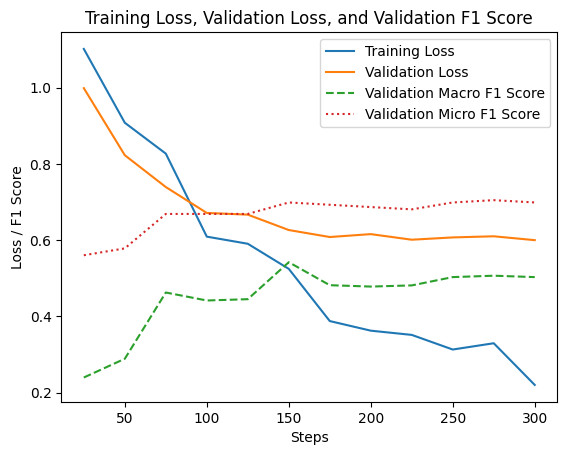

In [18]:
import matplotlib.pyplot as plt

# Extract training loss, validation loss, and F1 score
training_loss = []
validation_loss = []
validation_macro_f1 = []
validation_micro_f1 = []
eval_steps = []
train_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_macro_f1" in log:
        validation_macro_f1.append(log["eval_macro_f1"])
    if "eval_micro_f1" in log:
        validation_micro_f1.append(log["eval_micro_f1"])

# Plot the training and validation loss
plt.plot(train_steps, training_loss, label="Training Loss")
plt.plot(eval_steps, validation_loss, label="Validation Loss")
plt.plot(eval_steps, validation_macro_f1, label="Validation Macro F1 Score", linestyle="--")
plt.plot(eval_steps, validation_micro_f1, label="Validation Micro F1 Score", linestyle="dotted")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss / F1 Score")
plt.title("Training Loss, Validation Loss, and Validation F1 Score")
plt.legend()
plt.show()


In [19]:
# Load the F1 metric
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predicted labels by finding the index of the max logit
    predictions = np.argmax(logits, axis=-1)

    # Compute F1 scores for each class (average=None returns a list with F1 scores per class)
    f1_per_class = metric.compute(predictions=predictions, references=labels, average=None)

    # Compute macro-F1 score (mean of F1 for all classes)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    # Compute micro-F1 score (global F1 score)
    micro_f1 = metric.compute(predictions=predictions, references=labels, average="micro")

    return {
        "f1_class_0": f1_per_class["f1"][0],  # F1 for class 0
        "f1_class_1": f1_per_class["f1"][1],  # F1 for class 1
        "f1_class_2": f1_per_class["f1"][2],  # F1 for class 2
        "macro_f1": macro_f1["f1"],           # Overall macro F1
        "micro_f1": micro_f1["f1"],           # Overall micro F1
    }

In [20]:
for epochs in [8]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()

Step,Training Loss,Validation Loss,F1 Class 0,F1 Class 1,F1 Class 2,Macro F1,Micro F1
25,1.103200,0.996464,0.000000,0.000000,0.718147,0.239382,0.560241
50,0.907900,0.817599,0.133333,0.000000,0.732283,0.288539,0.578313
75,0.825600,0.737069,0.500000,0.000000,0.866310,0.455437,0.656627
100,0.603700,0.660729,0.442105,0.000000,0.882353,0.441486,0.668675
125,0.577300,0.662140,0.469388,0.000000,0.885572,0.451653,0.674699
150,0.506700,0.612734,0.554455,0.390244,0.884211,0.609637,0.722892
175,0.362900,0.597113,0.550459,0.000000,0.905263,0.485241,0.698795
200,0.333100,0.609325,0.571429,0.000000,0.909091,0.493506,0.704819
225,0.320900,0.599773,0.588235,0.166667,0.881356,0.545419,0.698795
250,0.265700,0.583756,0.681319,0.680000,0.910995,0.757438,0.813253


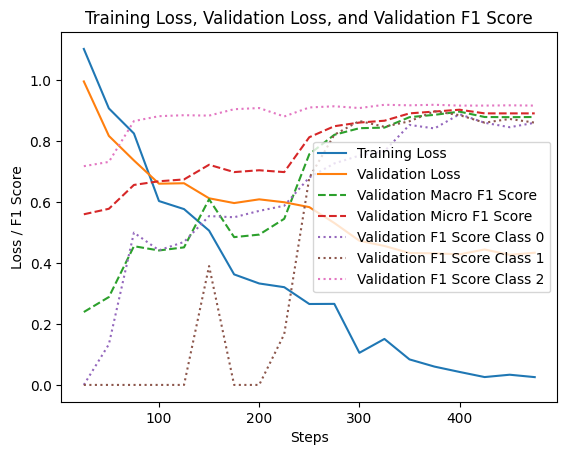

In [23]:
import matplotlib.pyplot as plt

# Extract training loss, validation loss, and F1 score
training_loss = []
validation_loss = []
validation_macro_f1 = []
validation_micro_f1 = []
eval_f1_class_0 = []
eval_f1_class_1 = []
eval_f1_class_2 = []
eval_steps = []
train_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_macro_f1" in log:
        validation_macro_f1.append(log["eval_macro_f1"])
    if "eval_micro_f1" in log:
        validation_micro_f1.append(log["eval_micro_f1"])
    if "eval_f1_class_0" in log:
        eval_f1_class_0.append(log["eval_f1_class_0"])
    if "eval_f1_class_1" in log:
        eval_f1_class_1.append(log["eval_f1_class_1"])
    if "eval_f1_class_2" in log:
        eval_f1_class_2.append(log["eval_f1_class_2"])

# Plot the training and validation loss
plt.plot(train_steps, training_loss, label="Training Loss")
plt.plot(eval_steps, validation_loss, label="Validation Loss")
plt.plot(eval_steps, validation_macro_f1, label="Validation Macro F1 Score", linestyle="--")
plt.plot(eval_steps, validation_micro_f1, label="Validation Micro F1 Score", linestyle="--")
plt.plot(eval_steps, eval_f1_class_0, label="Validation F1 Score Class 0", linestyle="dotted")
plt.plot(eval_steps, eval_f1_class_1, label="Validation F1 Score Class 1", linestyle="dotted")
plt.plot(eval_steps, eval_f1_class_2, label="Validation F1 Score Class 2", linestyle="dotted")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss / F1 Score")
plt.title("Training Loss, Validation Loss, and Validation F1 Score")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r {experiment_full_path} /content/drive/MyDrive

In [ ]:
def calculate_ece(y_true, y_prob, num_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

def plot_reliability_diagram_with_bars(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram with bars for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)

    # Ensure the lengths of prob_true and prob_pred match
    if len(prob_true) != len(prob_pred):
        min_len = min(len(prob_true), len(prob_pred))
        prob_true = prob_true[:min_len]
        prob_pred = prob_pred[:min_len]

    # Plot the reliability diagram with bars
    plt.figure(figsize=(8, 6))
    plt.bar(prob_pred, prob_true, width=0.1, edgecolor='k', alpha=0.7, label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram with Bars for Class {class_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])

# Compute the F1 score using your compute_metrics function
f1_score = compute_metrics((logits, true_labels))

# Print the F1 score
f1_score

{'f1_class_0': 0.6571428571428571,
 'f1_class_1': 0.84,
 'f1_class_2': 0.9072164948453608,
 'macro_f1': 0.801453117329406,
 'micro_f1': 0.8407643312101911}

For a three-label classification problem, you can calculate the reliability diagram and Expected Calibration Error (ECE) for each class by treating the problem as multiple binary classification tasks (one-vs-rest for each class). This is typically done by transforming the problem into three binary sub-problems, one for each class.



In [ ]:
calibration_curve(y_true, y_prob, *, pos_label=None, n_bins=5, strategy='uniform')

In [ ]:
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

bins=10

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")



In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])

probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

bins=10

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")

